In [28]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from tqdm import tqdm
from scipy import stats

In [2]:
device = torch.device('cuda:0')

In [3]:
GRAYSCALE = True

if GRAYSCALE:
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((310, 310)),
    #         transforms.Resize((224, 224)),
    #         transforms.CenterCrop(224),
            transforms.RandomResizedCrop(224),
    #         transforms.RandomHorizontalFlip(),
#             transforms.Grayscale(num_output_channels=3),
            transforms.RandomGrayscale(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((310, 310)),
    #         transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
    #         transforms.CenterCrop(224),
#             transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
else:
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((310, 310)),
    #         transforms.Resize((224, 224)),
    #         transforms.CenterCrop(224),
            transforms.RandomResizedCrop(224),
    #         transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((310, 310)),
    #         transforms.Resize((224, 224)),
            transforms.CenterCrop(224),
    #         transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }


In [4]:
class ImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_name = self.paths[idx]
        img = Image.open(img_name).convert('RGB')
        
        img_tensor = self.transform(img)

        return img_tensor, self.labels[idx]

In [5]:
train_file = 'bernie_interviews/data/train.txt'
val_file = 'bernie_interviews/data/val.txt'
test_file = 'bernie_interviews/data/test.txt'

In [6]:
def read_file(filename):
    paths = []
    labels = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            video, image, label = line.split(' ')
            paths.append('bernie_interviews/images/{}/{:04d}.jpg'.format(video, int(image)))
            labels.append(int(label))
            
    return paths, labels

In [7]:
train_paths, Y_train = read_file(train_file)
val_paths, Y_val = read_file(val_file)
test_paths, Y_test = read_file(test_file)

In [8]:
image_datasets = {
    'train': ImageDataset(train_paths, Y_train, transform = data_transforms['train']),
    'val': ImageDataset(val_paths, Y_val, transform = data_transforms['val']),
    'test': ImageDataset(test_paths, Y_test, transform = data_transforms['val'])
}

In [9]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=64,
                                              shuffle='train' in x,
                                              num_workers=16,
                                              pin_memory=True)
                                              for x in image_datasets}

In [10]:
dataset_sizes = {
    x: len(image_datasets[x])
    for x in image_datasets
}

In [11]:
dataset_sizes

{'train': 6835, 'val': 3026, 'test': 3563}

In [12]:
def safe_divide(a, b):
    return a / b if b > 0 else 0

In [13]:
def train_model(model, criterion, optimizer, scheduler, train_dl, val_dl, test_dl=None,
                num_epochs=25, return_best=False, verbose=True, log_file=None):
    print(train_dl, val_dl, test_dl)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    best_test_acc = 0.0
    best_f1 = 0.0
    best_precision = 0.0
    best_recall = 0.0
    
    phases = ['train', 'val', 'test'] if test_dl is not None else ['train', 'val']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
                dl = dataloaders[train_dl]
                dataset_size = dataset_sizes[train_dl]
                
            elif phase == 'val':
                model.eval()   # Set model to evaluate mode
                dl = dataloaders[val_dl]
                dataset_size = dataset_sizes[val_dl]
            else:
                model.eval()
                dl = dataloaders[test_dl]
                dataset_size = dataset_sizes[test_dl]

            running_loss = 0.0
            running_corrects = 0
            true_positives = 0.
            true_negatives = 0.
            false_positives = 0.
            false_negatives = 0.

            # Iterate over data.
            for inputs, labels in dl:
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.where(
                        outputs >= 0.,
                        torch.tensor([1.]).to(device),
                        torch.tensor([0.]).to(device))
                    target = torch.where(
                        labels >= 0.5,
                        torch.tensor([1.]).to(device),
                        torch.tensor([0.]).to(device)
                    )
                    loss = criterion(outputs.view(target.shape), target)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                label_vals = torch.where(
                    labels >= 0.5,
                    torch.tensor([1.]).to(device),
                    torch.tensor([0.]).to(device)
                )
                correct = preds.view(label_vals.shape) == label_vals.data
                running_corrects += torch.sum(correct)
                
                true_positives += torch.sum(
                    torch.where(
                        (correct == 1.) * (label_vals == 1.),
                        torch.tensor([1.]).to(device),
                        torch.tensor([0.]).to(device))
                )
                true_negatives += torch.sum(
                    torch.where(
                        (correct == 1.) * (label_vals == 0.),
                        torch.tensor([1.]).to(device),
                        torch.tensor([0.]).to(device))
                )
                false_positives += torch.sum(
                    torch.where(
                        (correct == 0.) * (label_vals == 0.),
                        torch.tensor([1.]).to(device),
                        torch.tensor([0.]).to(device))
                )
                false_negatives += torch.sum(
                    torch.where(
                        (correct == 0.) * (label_vals == 1.),
                        torch.tensor([1.]).to(device),
                        torch.tensor([0.]).to(device))
                )
            
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            epoch_pre = safe_divide(true_positives, (true_positives + false_positives))
            epoch_recall = safe_divide(true_positives, (true_positives + false_negatives))
            epoch_f1 = safe_divide(2 * epoch_pre * epoch_recall, (epoch_pre + epoch_recall))

            if verbose:
                print('{} Loss: {:.4f} Acc: {:.4f} Pre: {:.4f} Rec: {:.4f} F1: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc, epoch_pre, epoch_recall, epoch_f1))
                print('TP: {} TN: {} FP: {} FN: {}'.format(
                    true_positives.data, true_negatives.data, false_positives.data, false_negatives.data))
            if log_file is not None:
                log_file.write('Phase: {0}\t'
                               'Epoch: [{1}/{2}]\t'
                               'Loss: {loss_c:.4f}\t'
                               'Acc: {acc:.4f}\t'
                               'Pre: {pre:.4f}\t'
                               'Rec: {rec:.4f}\t'
                               'F1: {f1:.4f}\t'
                               'TP: {tp} '
                               'TN: {tn} '
                               'FP: {fp} '
                               'FN: {fn}\n'.format(
                                   phase, epoch + 1, num_epochs, loss_c=epoch_loss,
                                   acc=epoch_acc, pre=epoch_pre, rec=epoch_recall,
                                   f1=epoch_f1, tp=int(true_positives.data), tn=int(true_negatives.data),
                                   fp=int(false_positives.data), fn=int(false_negatives.data)
                               ))
                log_file.flush()

            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_acc = epoch_acc
                best_f1 = epoch_f1
                best_precision = epoch_pre
                best_recall = epoch_recall
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test' and best_epoch == epoch:
                best_test_acc = epoch_acc

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    if return_best:
        print('Best epoch: {}'.format(best_epoch))
        print('Best val Acc: {:4f}'.format(best_acc))
        print('Best val Pre: {:4f}'.format(best_precision))
        print('Best val Rec: {:4f}'.format(best_recall))
        print('Best val F1: {:4f}'.format(best_f1))
        print('Test Acc: {:4f}'.format(best_test_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
    return model

# Traditional Supervision

In [14]:
path = 'models/traditional_supervision_bs_interviews_grayscalerand_augmentation'
for seed in range(1):
    torch.manual_seed(seed)
    model_ts = models.resnet18(pretrained=True)
    num_ftrs = model_ts.fc.in_features
    model_ts.fc = nn.Linear(num_ftrs, 1)

    model_ts = model_ts.to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.]).to(device))

    # Observe that all parameters are being optimized
    optimizer_ts = optim.SGD(model_ts.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler_ts = lr_scheduler.StepLR(optimizer_ts, step_size=7, gamma=0.1)
    
    if not os.path.exists(path):
        os.makedirs(path)
    with open(os.path.join(path, 'seed_{}.log'.format(seed)), 'w') as log_file:
        model_ts = train_model(model_ts, criterion, optimizer_ts, exp_lr_scheduler_ts,
                               'train', 'val', test_dl='test', num_epochs=50, verbose=True,
                               log_file=log_file, return_best=True)
        torch.save(model_ts.state_dict(), os.path.join(path, 'seed_{}.pth'.format(seed)))

train val test
Epoch 0/49
----------
train Loss: 0.5030 Acc: 0.9318 Pre: 0.3020 Rec: 0.5833 F1: 0.3979
TP: 154.0 TN: 6215.0 FP: 356.0 FN: 110.0
val Loss: 0.1679 Acc: 0.9931 Pre: 0.8605 Rec: 0.8916 F1: 0.8757
TP: 74.0 TN: 2931.0 FP: 12.0 FN: 9.0
test Loss: 0.1605 Acc: 0.9941 Pre: 0.8981 Rec: 0.9065 F1: 0.9023
TP: 97.0 TN: 3445.0 FP: 11.0 FN: 10.0

Epoch 1/49
----------
train Loss: 0.2875 Acc: 0.9650 Pre: 0.5318 Rec: 0.7917 F1: 0.6362
TP: 209.0 TN: 6387.0 FP: 184.0 FN: 55.0
val Loss: 0.1335 Acc: 0.9954 Pre: 0.9259 Rec: 0.9036 F1: 0.9146
TP: 75.0 TN: 2937.0 FP: 6.0 FN: 8.0
test Loss: 0.1249 Acc: 0.9952 Pre: 0.9327 Rec: 0.9065 F1: 0.9194
TP: 97.0 TN: 3449.0 FP: 7.0 FN: 10.0

Epoch 2/49
----------
train Loss: 0.2302 Acc: 0.9716 Pre: 0.5926 Rec: 0.8485 F1: 0.6978
TP: 224.0 TN: 6417.0 FP: 154.0 FN: 40.0
val Loss: 0.1328 Acc: 0.9848 Pre: 0.6581 Rec: 0.9277 F1: 0.7700
TP: 77.0 TN: 2903.0 FP: 40.0 FN: 6.0
test Loss: 0.1286 Acc: 0.9829 Pre: 0.6456 Rec: 0.9533 F1: 0.7698
TP: 102.0 TN: 3400.0 FP: 5

test Loss: 0.0986 Acc: 0.9893 Pre: 0.7634 Rec: 0.9346 F1: 0.8403
TP: 100.0 TN: 3425.0 FP: 31.0 FN: 7.0

Epoch 25/49
----------
train Loss: 0.1022 Acc: 0.9852 Pre: 0.7477 Rec: 0.9318 F1: 0.8297
TP: 246.0 TN: 6488.0 FP: 83.0 FN: 18.0
val Loss: 0.1437 Acc: 0.9924 Pre: 0.8409 Rec: 0.8916 F1: 0.8655
TP: 74.0 TN: 2929.0 FP: 14.0 FN: 9.0
test Loss: 0.1006 Acc: 0.9893 Pre: 0.7717 Rec: 0.9159 F1: 0.8376
TP: 98.0 TN: 3427.0 FP: 29.0 FN: 9.0

Epoch 26/49
----------
train Loss: 0.0889 Acc: 0.9868 Pre: 0.7652 Rec: 0.9508 F1: 0.8480
TP: 251.0 TN: 6494.0 FP: 77.0 FN: 13.0
val Loss: 0.1400 Acc: 0.9927 Pre: 0.8427 Rec: 0.9036 F1: 0.8721
TP: 75.0 TN: 2929.0 FP: 14.0 FN: 8.0
test Loss: 0.0994 Acc: 0.9896 Pre: 0.7734 Rec: 0.9252 F1: 0.8426
TP: 99.0 TN: 3427.0 FP: 29.0 FN: 8.0

Epoch 27/49
----------
train Loss: 0.1035 Acc: 0.9867 Pre: 0.7695 Rec: 0.9356 F1: 0.8444
TP: 247.0 TN: 6497.0 FP: 74.0 FN: 17.0
val Loss: 0.1395 Acc: 0.9931 Pre: 0.8444 Rec: 0.9157 F1: 0.8786
TP: 76.0 TN: 2929.0 FP: 14.0 FN: 7.0
tes

val Loss: 0.1369 Acc: 0.9927 Pre: 0.8352 Rec: 0.9157 F1: 0.8736
TP: 76.0 TN: 2928.0 FP: 15.0 FN: 7.0
test Loss: 0.0975 Acc: 0.9896 Pre: 0.7692 Rec: 0.9346 F1: 0.8439
TP: 100.0 TN: 3426.0 FP: 30.0 FN: 7.0

Training complete in 18m 16s
Best epoch: 1
Best val Acc: 0.995373
Best val Pre: 0.925926
Best val Rec: 0.903614
Best val F1: 0.914634
Test Acc: 0.995229


## Visualize Mistakes

In [15]:
path = 'models/traditional_supervision_bs_interviews_grayscalerand_augmentation'
model_ts = models.resnet18(pretrained=True)
num_ftrs = model_ts.fc.in_features
model_ts.fc = nn.Linear(num_ftrs, 1)
model_ts.load_state_dict(torch.load(
    os.path.join(path, 'seed_0.pth')
))
model_ts.to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.]).to(device))

In [16]:
model_ts.eval()   # Set model to evaluate mode
dl = dataloaders['val']
dataset_size = dataset_sizes['val']

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(str(title))
    plt.pause(0.001)  # pause a bit so that plots are updated

tensor(1., device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')
3


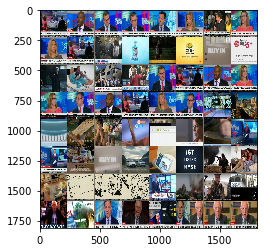

tensor(1., device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
9


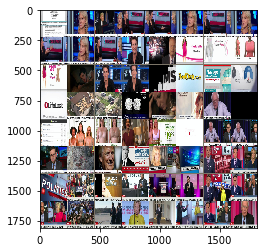

tensor(1., device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
22


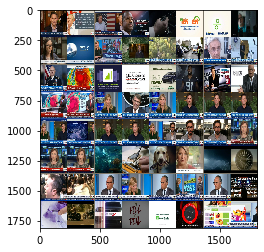

tensor(2., device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
27


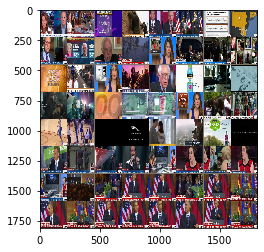

tensor(1., device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
39


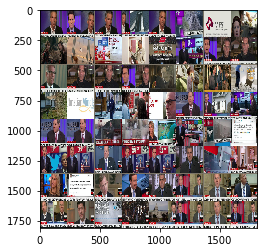

In [18]:
# optimizer = optimizer_ts
model = model_ts
model.eval()
# Iterate over data.
i = 0
for inputs, labels in dl:
    inputs = inputs.to(device)
    labels = labels.to(device).float()

    # zero the parameter gradients
    # optimizer.zero_grad()

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        preds = torch.where(
            outputs >= 0.,
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device))
        target = torch.where(
            labels >= 0.5,
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device)
        )
#         loss = criterion(outputs.view(target.shape), target)

    # statistics
    label_vals = torch.where(
        labels >= 0.5,
        torch.tensor([1.]).to(device),
        torch.tensor([0.]).to(device)
    )
    correct = preds.view(label_vals.shape) == label_vals.data
    
    num_fp = torch.sum(
        torch.where(
            (correct == 0.) * (label_vals == 0.),
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device))
    )

    if num_fp > 0:
        print(num_fp)
        print(torch.where(
            (correct == 0.) * (label_vals == 0.),
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device)))
        print(i)
        out = torchvision.utils.make_grid(inputs)
#         imshow(out, title=preds.cpu().numpy().tolist())
        imshow(out)
        
    i += 1

tensor(1., device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')
0


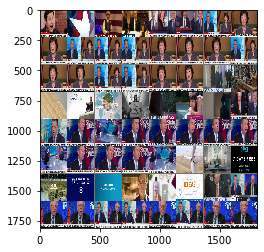

tensor(1., device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
1


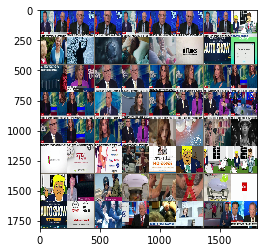

tensor(2., device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
2


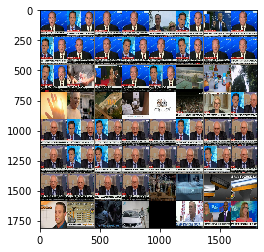

tensor(1., device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
3


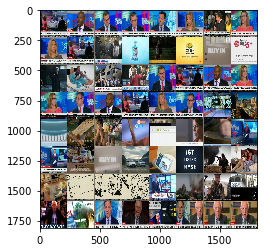

tensor(2., device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
4


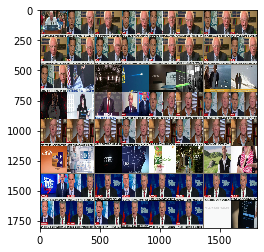

tensor(1., device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
7


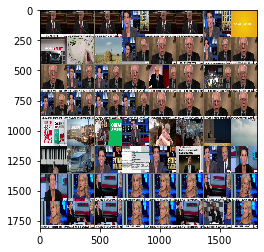

In [19]:
# optimizer = optimizer_ts
model = model_ts
model.eval()
# Iterate over data.
i = 0
for inputs, labels in dl:
    inputs = inputs.to(device)
    labels = labels.to(device).float()

    # zero the parameter gradients
    # optimizer.zero_grad()

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        preds = torch.where(
            outputs >= 0.,
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device))
        target = torch.where(
            labels >= 0.5,
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device)
        )
#         loss = criterion(outputs.view(target.shape), target)

    # statistics
    label_vals = torch.where(
        labels >= 0.5,
        torch.tensor([1.]).to(device),
        torch.tensor([0.]).to(device)
    )
    correct = preds.view(label_vals.shape) == label_vals.data
    
    num_fn = torch.sum(
        torch.where(
            (correct == 0.) * (label_vals == 1.),
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device))
    )

    if num_fn > 0:
        print(num_fn)
        print(torch.where(
            (correct == 0.) * (label_vals == 1.),
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device)))
        print(i)
        out = torchvision.utils.make_grid(inputs)
#         imshow(out, title=preds.cpu().numpy().tolist())
        imshow(out)
        
    i += 1

# With post-processing of results

In [118]:
# optimizer = optimizer_ts
model = model_ts
model.eval()
# Iterate over data.
i = 0
predictions = []
gt_labels = []
for inputs, labels in tqdm(dl):
    inputs = inputs.to(device)
    labels = labels.to(device).float()

    # zero the parameter gradients
    # optimizer.zero_grad()

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        preds = torch.where(
            outputs >= 0.,
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device))
        target = torch.where(
            labels >= 0.5,
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device)
        )
#         loss = criterion(outputs.view(target.shape), target)
    predictions += preds.cpu().numpy().tolist()
    gt_labels += labels.cpu().numpy().tolist()

100%|██████████| 48/48 [00:04<00:00, 10.37it/s]


In [120]:
predictions = [p[0] for p in predictions]

In [105]:
def pos_negs(predictions, gt):
    correct = np.where(np.array(predictions) == np.array(gt), 1, 0)
    incorrect = np.where(np.array(predictions) == np.array(gt), 0, 1)
    
    tp = np.where(correct * np.where(predictions == np.array(1), 1, 0), 1, 0)
    tn = np.where(correct * np.where(predictions == np.array(0), 1, 0), 1, 0)
    fp = np.where(incorrect * np.where(predictions == np.array(1), 1, 0), 1, 0)
    fn = np.where(incorrect * np.where(predictions == np.array(0), 1, 0), 1, 0)
    
    return tp, tn, fp, fn

In [106]:
def prf1(predictions, gt):
    tp, tn, fp, fn = pos_negs(predictions, gt)
    
    precision = np.sum(tp) / (np.sum(tp) + np.sum(fp))
    recall = np.sum(tp) / (np.sum(tp) + np.sum(fn))
    f1 = 2 * precision * recall / (precision + recall)
    
    return precision, recall, f1, np.sum(tp), np.sum(tn), np.sum(fp), np.sum(fn)

## No post-processing

In [122]:
prf1(predictions, gt_labels)

(0.9259259259259259, 0.9036144578313253, 0.9146341463414634, 75, 2937, 6, 8)

In [127]:
tp, tn, fp, fn = pos_negs(predictions, gt_labels)

In [128]:
np.where(tp == np.array(1))

(array([ 55,  56,  57,  58,  59,  60,  61,  62,  64,  65,  67,  68,  69,
         70, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 253, 254, 255, 257,
        258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
        271, 272, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469,
        470, 471, 472, 473, 474, 475, 476, 477, 478, 479]),)

In [129]:
np.where(fp == np.array(1))

(array([ 251,  606, 1422, 1738, 1748, 2512]),)

In [130]:
np.where(fn == np.array(1))

(array([ 63,  66, 157, 158, 252, 256, 273, 458]),)

## With post-processing

In [150]:
def smooth_predictions(preds, window_radius = 3):
    result = []
    for i in range(len(preds)):
        start = max(0, i - window_radius)
        end = min(len(preds), i + window_radius)
        window = preds[start:end]
        result += [max(window, key=window.count)]
    
    return result

In [161]:
smoothed_preds = smooth_predictions(predictions, 3)

In [162]:
prf1(smoothed_preds, gt_labels)

(0.9620253164556962, 0.9156626506024096, 0.9382716049382716, 76, 2940, 3, 7)

In [163]:
tp, tn, fp, fn = pos_negs(smoothed_preds, gt_labels)

In [164]:
np.where(fp == np.array(1))

(array([ 71, 180, 480]),)

In [165]:
np.where(tp == np.array(1))

(array([ 56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 253, 254, 255, 256,
        257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
        270, 271, 272, 273, 460, 461, 462, 463, 464, 465, 466, 467, 468,
        469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479]),)

In [166]:
np.where(fn == np.array(1))

(array([ 55, 157, 158, 159, 252, 458, 459]),)

## Run on test set

In [167]:
dl = dataloaders['test']
dataset_size = dataset_sizes['test']

In [168]:
# optimizer = optimizer_ts
model = model_ts
model.eval()
# Iterate over data.
i = 0
predictions = []
gt_labels = []
for inputs, labels in tqdm(dl):
    inputs = inputs.to(device)
    labels = labels.to(device).float()

    # zero the parameter gradients
    # optimizer.zero_grad()

    # forward
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        preds = torch.where(
            outputs >= 0.,
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device))
        target = torch.where(
            labels >= 0.5,
            torch.tensor([1.]).to(device),
            torch.tensor([0.]).to(device)
        )
#         loss = criterion(outputs.view(target.shape), target)
    predictions += preds.cpu().numpy().tolist()
    gt_labels += labels.cpu().numpy().tolist()

100%|██████████| 56/56 [00:05<00:00, 19.48it/s]


In [171]:
predictions = [p[0] for p in predictions]

In [172]:
prf1(predictions, gt_labels)

(0.9326923076923077, 0.9065420560747663, 0.919431279620853, 97, 3449, 7, 10)

In [173]:
smoothed_preds = smooth_predictions(predictions, 3)

In [174]:
prf1(smoothed_preds, gt_labels)

(0.9514563106796117, 0.9158878504672897, 0.9333333333333335, 98, 3451, 5, 9)